In [1]:
from SIFT_gs.FIBSEM_SIFT_gs import *

Open CV version:  4.6.0
SIFT_gs version:  4.0.1


# Set up Local DASK Client and Monitor Window

In [2]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address0 = 'http://localhost:{:d}/status'.format(dport)
print('Use ' + status_update_address0 +' to monitor DASK progress')
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

Using Local Port:    8787


# Step 0a: Select the Source Directory and Source Files.

In [3]:
fls_dir = os.path.normpath('Y:/Images Jeiss1/Cryo/Y2024/M02')
days = ['D{:02d}'.format(day) for day in np.arange(9, 11)]
days

['D09', 'D10']

In [4]:
fls=[]
ftype=0
for day in days:
    fls_dir1 = os.path.join(fls_dir, day)
    if ftype == 0:
        fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*.dat')))
        if len(fls1) < 1:
            fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*/*.dat')))
    if ftype == 1:
        fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*.tif')))
        if len(fls1) < 1:
            fls1 = sorted(glob.glob(os.path.join(fls_dir1,'*/*.tif')))
    fls = fls + fls1
fls = fls[100:]
nfrs = len(fls)
print('Total Number of frames to process: ', nfrs) 

Total Number of frames to process:  192


# Notes from Jeiss1 machine






# Step 0b: Set up Processing Parameters.

In [5]:
# set the results directory
#data_dir = 'F:/FIB-SEM_SIFT/Test_data/LID494_ROI5_RawData'
data_dir = os.path.normpath('Y:/Images Jeiss1/Cryo/Y2024/M02/D09/results')

ftype = 0 # 0 for Shan's .dat files, 1 for tif files

use_DASK = True
DASK_client_retries = 3  # Number of allowed automatic retries if a task fails

threshold_min = 1e-3    # These are used to determine Min and Max data boundaries for I8 conversion
threshold_max = 1e-3                            
sliding_minmax = True   # If True, Global Min and Max for I8 conversion the entire data set is used. If False, Min and Max are allowed to vary slowly.
nbins = 256             # Number of histogram bins for determining Min and Max above

BFMatcher = False       # If True, the BF Matcher is used for keypont matching
                        # otherwise FLANN Matcher (faster, preferable) is used.

save_matches = True     # If True, matches will be saved into individual files

kp_max_num = 100000      # max number of key-points to be matched. Key-points in every frame are indexed (in descending order)
                        # by the strength of the response. Only kp_max_num is kept for further processing.
                        # Set this value to -1 if you want to keep ALL keypoints (may take forever to process!)

# Uncomment one from the below choices:
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if TransformType == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])       # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

SIFT_nfeatures = 0     # SIFT libary default is 0. The number of best features to retain.
                                # The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    
SIFT_nOctaveLayers = 3          # SIFT libary default  is 3. The number of layers in each octave.
                                # 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

SIFT_contrastThreshold = 0.025   # SIFT libary default  is 0.04. The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
                                # The larger the threshold, the less features are produced by the detector.
                                # The contrast threshold will be divided by nOctaveLayers when the filtering is applied.
                                # When nOctaveLayers is set to default and if you want to use the value used in
                                # D. Lowe paper (0.03), set this argument to 0.09.
                                
SIFT_edgeThreshold = 10         # SIFT libary default  is 10. The threshold used to filter out edge-like features.
                                # Note that the its meaning is different from the contrastThreshold,
                                # i.e. the larger the edgeThreshold, the less features are filtered out
                                # (more features are retained).

SIFT_sigma = 1.6                # SIFT library default is 1.6. 	The sigma of the Gaussian applied to the input image at the octave #0.
                                # If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    
Lowe_Ratio_Threshold = 0.7

solver = 'RANSAC'       # String indicating which solver is to be used.'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.
                        # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic

drmax = 1.5              # dimensions - pixels.
                         #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.
                         #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                         # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                         # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                         # until the worst error falls below drmax or the max number of iterations is reached.

max_iter = 1000             # max number of iterations in the iterative procedure above

save_data_as_tiff = False    # Convert and Save the InLens.tif data

save_res_png = True          # Save PNG images of the intemediate processing statistics and final registration quality check.

dtp = int16                  # Python data type for saving. Deafult is int16, the other option currently is uint8.

preserve_scales = True       # If True, the transformation matrix will be adjusted using the settings defined by fit_params below
fit_params = ['SG', 101, 3]  # perform the above adjustment using  Savitzky-Golay (SG) filter with parameters
                             # window size 501, polynomial order 3
#fit_params = ['LF']         # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)

subtract_linear_fit = [True, True]  # If True, the linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
                                    # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 
subtract_FOVtrend_from_fit = [True, True]  # If True, FOV trends (image shifts performed during imaging) will be subtracted first, so they do not bias the linear trends.

pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

flipY = False                 # If True, the dataset will be flipped along Y-direction

zbin_factor =  1             # binning factor in z-direction (milling direction). Data will be binned when saving the final result. Default is 1.

eval_metrics = ['NSAD', 'NCC', 'NMI']   # list of metrics used for evaluation of registration (and resolution).
                                        # Options are; 'NSAD', 'NCC', 'NMI', 'FSC'
fnm_types = ['mrc']    #   File type(s) for output data. Options are: ['h5', 'mrc'].
                             # Defauls is ['mrc']. 
                             # 'h5' is BigDataViewer HDF5 format, uses npy2bdv package. Use empty list if do not want to save the data.

int_order = 1                #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic
                        
                        

#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************           

if fit_params[1] > nfrs//2*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//2*2-1

fnm0 = (os.path.join(data_dir,fls[0]))
frame0 = FIBSEM_frame(fnm0, ftype=ftype)
Sample_ID = frame0.Sample_ID.strip('/x00')
EightBit = frame0.EightBit

SIFT_kwargs = {
    'ftype' : ftype,
    'data_dir' : data_dir,
    'Sample_ID' : Sample_ID,
    'EightBit' : EightBit,
    'use_DASK' : use_DASK,
    'DASK_client_retries' : DASK_client_retries,
    'threshold_min' : threshold_min, 
    'threshold_max' : threshold_max,
    'sliding_minmax' : sliding_minmax,
    'nbins' : nbins,
    'TransformType' : TransformType,
    'SIFT_nfeatures' : SIFT_nfeatures,
    'SIFT_nOctaveLayers' : SIFT_nOctaveLayers,
    'SIFT_contrastThreshold' : SIFT_contrastThreshold,
    'SIFT_edgeThreshold' : SIFT_edgeThreshold,
    'SIFT_sigma' : SIFT_sigma,
    'Lowe_Ratio_Threshold' : Lowe_Ratio_Threshold,
    'l2_matrix' : l2_matrix,
    'targ_vector': targ_vector, 
    'solver' : solver,
    'drmax' : drmax,
    'max_iter' : max_iter,
    'BFMatcher' : BFMatcher,
    'save_matches' : save_matches,
    'kp_max_num' : kp_max_num,
    'save_res_png' : save_res_png,
    'save_data_as_tiff' : save_data_as_tiff,
    'dtp' : dtp,
    'preserve_scales' : preserve_scales,
    'fit_params' : fit_params,
    'subtract_linear_fit' : subtract_linear_fit,
    'subtract_FOVtrend_from_fit' : subtract_FOVtrend_from_fit,
    'pad_edges' : pad_edges,
    'flipY' : flipY,
    'zbin_factor' : zbin_factor,
    'eval_metrics' : eval_metrics,
    'fnm_types' : fnm_types,
    'int_order' : int_order,
    'suffix' : suffix}

test_dataset = FIBSEM_dataset(fls, fnm_reg = 'Registered_brat0.00.mrc', **SIFT_kwargs)

Registered data will be saved into:  Registered_brat0.00.mrc
Total Number of frames:  192


header scaling data: [[ 1.00000000e+06  1.00000000e+06]
 [-6.16065332e+03  3.08718530e+03]
 [ 1.32474169e-01  5.76236434e-02]
 [ 1.00000000e-01  1.00000000e-01]]
The EM data range for display:            -3327.5 - -1743.7
The EM data range for noise analysis:     -3245.7 - -1974.9
popt:  [2.8861341e+00 1.5472365e+04]
I_array:  [-3245.74051241 -1974.93073422 -3002.73042376]
Slope of linear fit with header offset: 2.23
Var at peak: 6806.1
PSNR=28.58, PSNR_header=38.28, DSNR=15.40
results saved into the file: Y:\Images Jeiss1\Cryo\Y2024\M02\D09\results\Gemini500-7029_24-02-09_094242_0-0-0_RawImageA_Noise_Analysis.png
The EM data range for display:            -3414.6 - -475.9
The EM data range for noise analysis:     -3121.7 - -990.2
popt:  [1.26826847e+02 7.69326768e+05]
I_array:  [-3121.72437438  -990.15764924 -2479.04317018]
Slope of linear fit with header offset: -102.19
Var at peak: 454917.5
PSNR=5.32, PSNR_header=-8.25, DSNR=3.16
results saved into the file: Y:\Images Jeiss1\Cryo\Y20

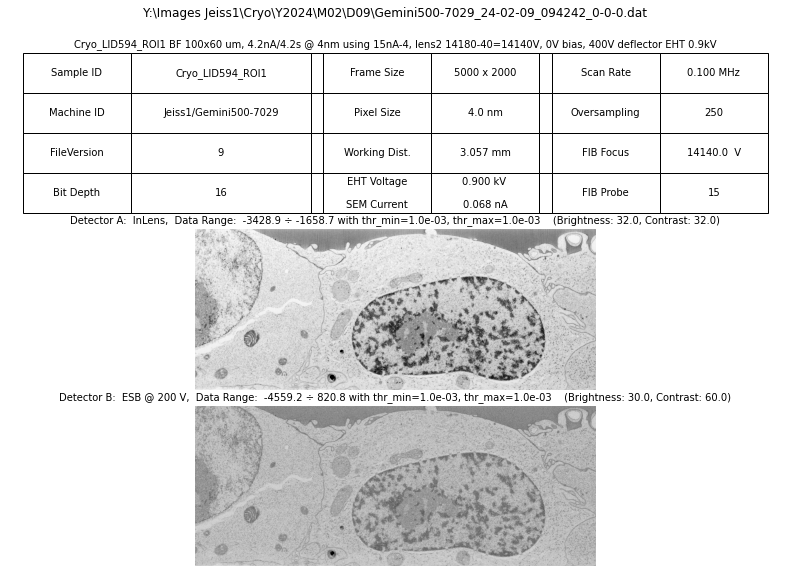

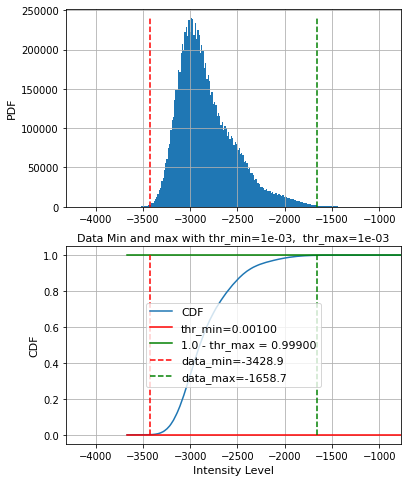

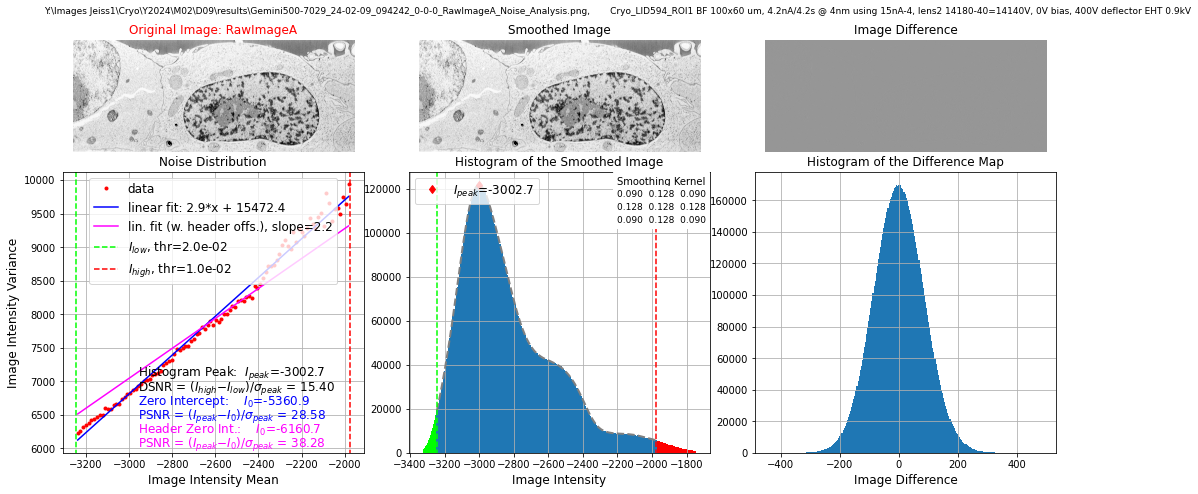

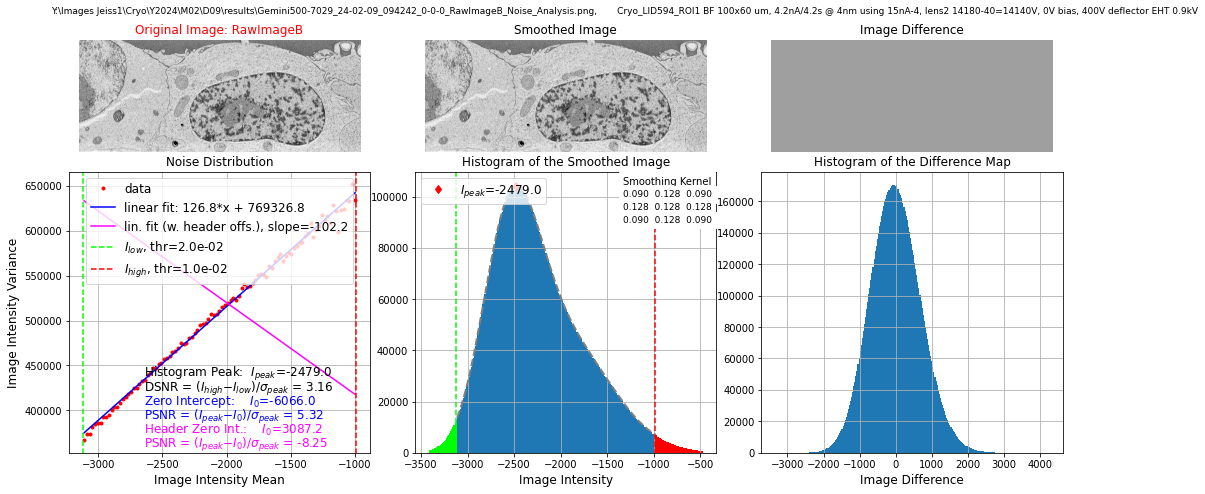

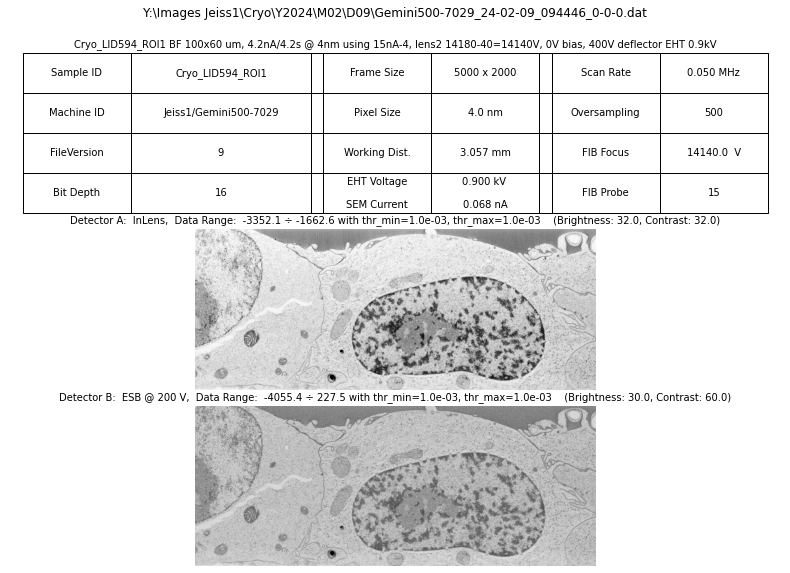

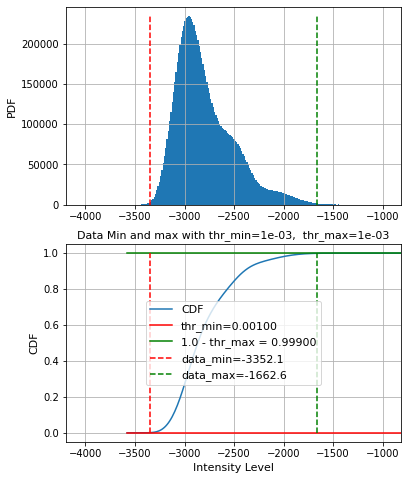

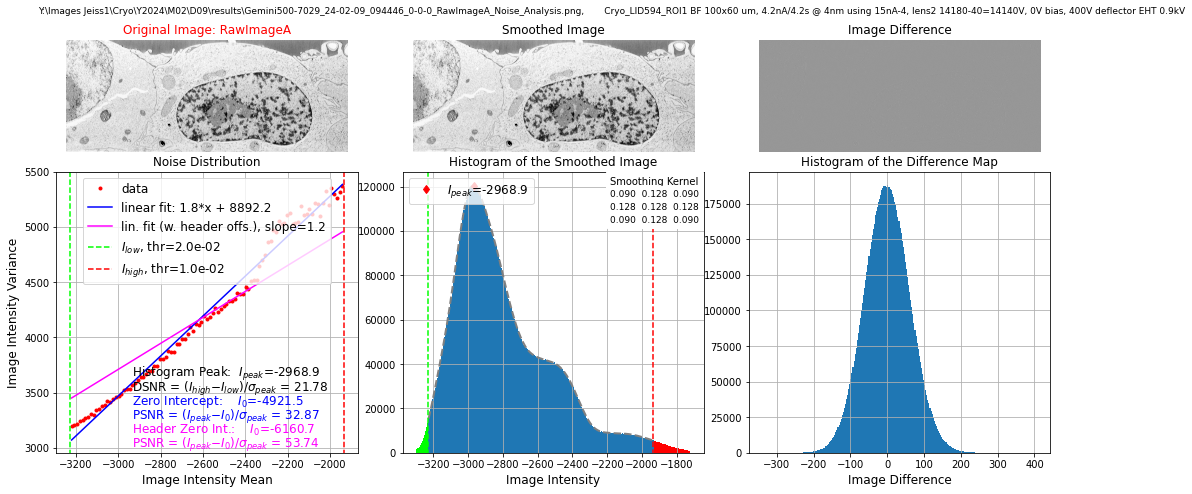

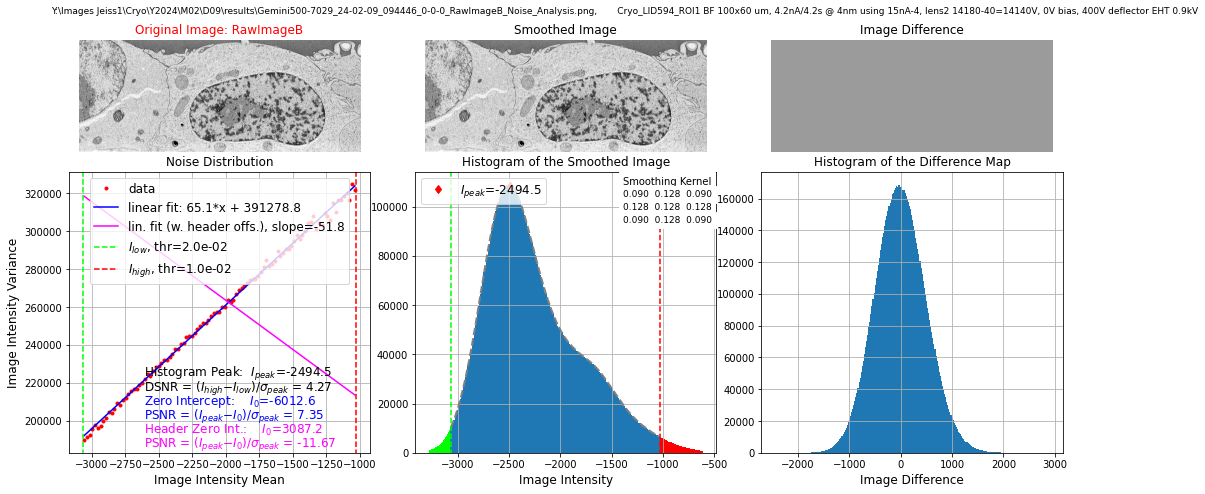

In [6]:
fr_inds = [190, 191]
for fr_ind in fr_inds:
    test_frame = FIBSEM_frame(fls[fr_ind])
    test_frame_suff = Path(test_frame.fname).suffix
    snapshot_name = os.path.join(data_dir, os.path.split(fls[fr_ind])[1].replace(test_frame_suff, '_snapshot.png'))
    test_frame.save_snapshot(snapshot_name=snapshot_name)
    get_min_max_thresholds(test_frame.RawImageA, disp_res=True)
    test_frame.save_images_tif()

    print('header scaling data:', test_frame.Scaling)
    image_name = 'RawImageA'
    res_fname = os.path.join(data_dir, os.path.split(fls[fr_ind])[1].replace(test_frame_suff, '_' + image_name + '_Noise_Analysis.png'))
    RawImageA_results = test_frame.analyze_noise_statistics(image_name=image_name, res_fname = res_fname)
    image_name = 'RawImageB'
    res_fname = os.path.join(data_dir, os.path.split(fls[fr_ind])[1].replace(test_frame_suff, '_' + image_name + '_Noise_Analysis.png'))
    RawImageA_results = test_frame.analyze_noise_statistics(image_name=image_name, res_fname = res_fname)

# Check the settings: Perform SIFT alignements on two frames in the middle of the stack

Cryo_LID594_ROI1
Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 1.00004764e+00  2.12947268e-04  1.08003762e-01]
 [ 1.26297001e-04  9.99931628e-01 -8.32748627e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
8332 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 2001
Wall time: 57.9 s


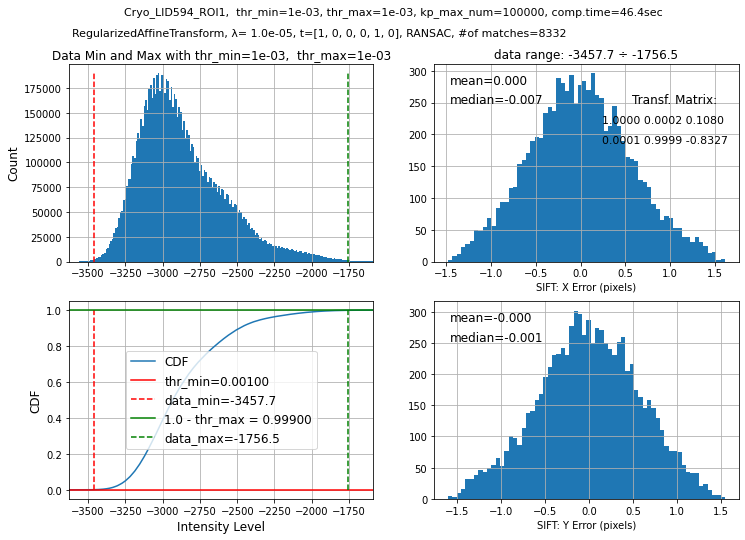

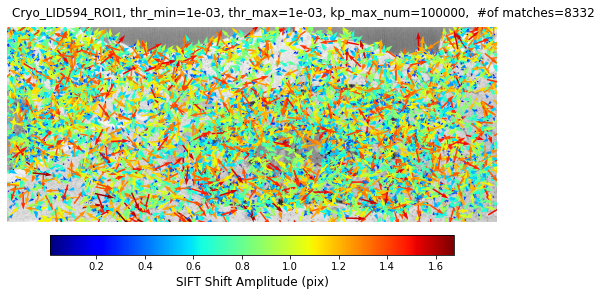

In [7]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation()

# This is where the data processing begins. Perform SIFT Computations using DASK Distributed (local cluster, using SCATTER, MAP and GATHER)

# Step 2: Save InLens.tif Data (Optional)

In [8]:
if save_data_as_tiff:
    test_dataset.convert_raw_data_to_tif_files(DASK_client = client)

# Step 2b: Step 2b: Evaluate parameters of FIBSEM data set (Data Min/Max, Working Distance, Milling Y Voltage, FOV center positions)

In [ ]:
%%time
FIBSEM_Data = test_dataset.evaluate_FIBSEM_statistics(DASK_client = client)
generate_report_mill_rate_xlsx(FIBSEM_Data[0])
generate_report_FOV_center_shift_xlsx(FIBSEM_Data[0])
generate_report_data_minmax_xlsx(FIBSEM_Data[0])
generate_report_ScanRate_EHT_xlsx(FIBSEM_Data[0])

DASK client exists. Will perform distributed computations
Use http://localhost:8787/status to monitor DASK progress
Evaluating the parameters of FIBSEM data set (data Min/Max, Working Distance, Milling Y Voltage, FOV center positions, Scan Rate, EHT)
Using DASK distributed


# Steps 3 and 4: Extract Key Points and Descriptors, Find Matches and Transformations

In [ ]:
%%time
# Step 3: Extract Key Points and Descriptors using DASK Distributed
t1 = time.time()
print('Step 3: Extract Key Points and Descriptors')
fnms = test_dataset.extract_keypoints(DASK_client = client)   
t2 = time.time()
print('Step 3: Elapsed time: {:.2f} seconds'.format(t2 - t1))
print('')

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if test_dataset.TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(DASK_client = client)
t3 = time.time()
print('Step 4: Elapsed time: {:.2f} seconds'.format(t3 - t2))

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

In [ ]:
# here is an example of how the previous step can be modified easily without having to re-do all previous steps
# this will calculate the cumulative transformation matrix WITHOT modifying the object property subtract_linear_fit
# so this change will NOT propagate.
# tr_matr_cum_residual = test_dataset.process_transformation_matrix(subtract_linear_fit = [False, True])

# if you want to make permanet change, then you should do this:
# test_dataset.subtract_linear_fit = [False, True]
# tr_matr_cum_residual = test_dataset.process_transformation_matrix()


# Step 5: Search for frames with no (or low # of) matches and possibly remove them.

In [ ]:
thr_npt = 3   # consider frame with less than 3 Key Points for removal
tr_matr_cum_residual = test_dataset.check_for_nomatch_frames(thr_npt, **SIFT_kwargs)

# Step 6: Recall or Save the Intermediate Data (KeyPoints, Matches, Transf.Matrix, etc.) from / into spreadsheets and a binary files.  Remove the intermediate KeyPoint/Descriptor files.

In [ ]:
recall_the_data = False          # if False, the data will be saved. if True, the data will be recalled

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))

if recall_the_data:
    test_dataset = FIBSEM_dataset(fls, recall_parameters=True, dump_filename=dump_filename, disp_res=True, **SIFT_kwargs)
else:
    saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
    print('Parameters saved into the file: ', saved_dump_file)

In [ ]:
remove_key_points_data = False   # if True, the binary files with intermediate keypoints data for each frame will be removed

# Remove temporary files
if remove_key_points_data:
    # Remove the keypoint/ descriptor files
    for fnm in tqdm(fnms, desc='Removing KeyPoint/Descriptor Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass
    for fnm in tqdm(fnms_matches, desc='Removing Matched KeyPoint Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass

# Define Evaluation Box

In [ ]:
#evaluation_box = [250, 2000, 1450, 2650]      # optional evaluation box for defining the area over which the registration quality
#test_dataset.show_eval_box(evaluation_box = evaluation_box, invert_data=False)
#
# default frames are three frames: 10% from the start, 50% from the start, and 90% from the start
# alternatively you can set any list of frame indecis by using keyword frame_indices
# for example:0
# test_dataset.show_eval_box(frame_indices=[1, 100, 850], evaluation_box = evaluation_box, invert_data=False)
#
fr_ind = 100
evaluation_box = [500, 1000, 1500, 1000]
test_dataset.show_eval_box(invert_data=False, frame_inds=[fr_ind], evaluation_box=evaluation_box)

# Evaluate Image B fraction for fused image using Auto-Correlation and Cross-Correlation

In [ ]:
%%time
fr_ind=190
evaluation_box = [500, 1000, 1500, 1000]
test_dataset.estimate_SNRs(frame_inds=[fr_ind],
                           ImgB_fraction = 0.02,
                           perform_transformation = False,
                           evaluation_box = evaluation_box, save_res_png=True)

In [ ]:
%%time
fr_ind=191
evaluation_box = [500, 1000, 1500, 1000]
test_dataset.estimate_SNRs(frame_inds=[fr_ind],
                           ImgB_fraction = 0.02,
                           perform_transformation = False,
                           evaluation_box = evaluation_box, save_res_png=True)

In [ ]:
%%time
evaluation_box = [500, 1000, 1500, 1000]
frame_inds = 160 + np.arange(5)
ImgB_fractions = np.linspace(0.00, 0.12, 13)
ImgB_fr_optimal_mid = test_dataset.evaluate_ImgB_fractions(ImgB_fractions, frame_inds,
                                                           DASK_client=client, use_DASK=True,
                                                           evaluation_box = evaluation_box)

# Step 7: Transform and Save the FIB-SEM data

In [ ]:
evaluation_box = [300, 1500, 500, 4000]
test_dataset.show_eval_box(invert_data=False,
                           frame_inds = [nfrs//5, nfrs//2, nfrs//5*4],
                           evaluation_box=evaluation_box)

In [ ]:
%%time

print('Step 7: Transform and Save the FIB-SEM data')

test_dataset.fnm_reg = 'LID594_ROI1b_RegAffine_l2_1e-05_brat0.00.mrc'

evaluation_box = [300, 1500, 500, 4000]

reg_summary_RegAffine_ImB0p00_flattened, reg_summary_RegAffine_ImB0p00_flattened_xlsx = test_dataset.transform_and_save(DASK_client = client,
                                                        save_transformed_dataset = True,
                                                        save_registration_summary = True,
                                                        flatten_image = False,
                                                        ImgB_fraction=0.00,
                                                        add_offset = True,
                                                        zbin_factor = 1,
                                                        evaluation_box = evaluation_box,
                                                        sliding_evaluation_box = False,
                                                        fnm_types = ['mrc'])

generate_report_from_xls_registration_summary(reg_summary_RegAffine_ImB0p00_flattened_xlsx)

In [ ]:
file_xlsx = 'Z:\Python_Scripts\FIB-SEM_SIFT\Test_data\J1_LID596_ROI2\M07\LID596_ROI2i_RegAffine_l2_1e-05_brat0.00_RegistrationQuality.xlsx'
Regisration_data = pd.read_excel(file_xlsx, sheet_name='Registration Quality Statistics')
fig, ax = subplots(1,1, figsize=(7,5))
frame = Regisration_data['Frame']
ncc = Regisration_data['NCC']
ax.plot(frame, ncc)
ax.grid(True)
ax.set_xlabel('Frame')
ax.set_ylabel('NCC')

ncc_mean = np.mean(ncc[80:180])
SNR_mean = ncc_mean/(1.0-ncc_mean)
print('NCC Mean (100kHz) = {:.4f}'.format(ncc_mean))
print('SNR Mean (100kHz) = {:.4f}'.format(SNR_mean))

# Evaluate 100kHz Data

In [ ]:
inds = np.arange(80, 180, 1)

evaluation_box = [500, 1000, 900, 1000]

test_dataset.show_eval_box(invert_data=False,
                           frame_inds = [inds[0], inds[-1]],
                           evaluation_box=evaluation_box)

test_frame = FIBSEM_frame(fls[inds[0]])
xi = evaluation_box[2]
xa = xi+evaluation_box[3]
yi = evaluation_box[0]
ya = yi+evaluation_box[1]
get_min_max_thresholds(test_frame.ImageA[yi:ya, xi:xa], disp_res=True)

In [ ]:
%%time

min_sigma = 1.0          # sigma (in pixel units) for Gaussian kernel in LoG search
max_sigma = 1.6          # sigma (in pixel units) for Gaussian kernel in LoG search
threshold = 3500        # threshold for LoG search. The absolute lower bound for scale space maxima. Local maxima smaller
                         # than threshold are ignored. Reduce this to detect blobs with less intensities
overlap = 0.1            # A value between 0 and 1. If the area of two blobs overlaps by a fraction greater than 'overlap', the smaller blob is eliminated.
pixel_size = 4.0         #  pixel size in nm
subset_size = 16         #  subset size (pixels) for blob / transition analysis
bounds = [0.37, 0.63]    #  List of of transition limits
bands = [5, 5, 5]        # list of three ints for the averaging bands for determining the left min, peak, and right min of the cross-section profile.
min_thr = 0.4            # threshold for identifying a 'good' transition (bottom < min_thr* top)

perform_transformation = False

if perform_transformation:
    results_file_xlsx =os.path.join(data_dir, os.path.splitext(test_dataset.fnm_reg)[0]+'_transformed_2D_blob_analysis_results.xlsx')
else:
    results_file_xlsx =os.path.join(data_dir, os.path.splitext(test_dataset.fnm_reg)[0]+'_raw_2D_blob_analysis_results.xlsx')

results = test_dataset.estimate_resolution_blobs_2D(DASK_client=client,
                                               use_DASK=True,
                                               image_name='ImageA',
                                               frame_inds = inds,
                                               evaluation_box=evaluation_box,
                                              min_sigma = min_sigma,
                                              max_sigma = max_sigma,
                                              threshold = threshold,
                                              overlap = overlap,
                                              pixel_size = pixel_size,
                                              subset_size = subset_size,
                                              bounds = bounds,
                                              bands = bands,
                                              min_thr = min_thr,
                                              title = fls[inds[0]],
                                              verbose = False,
                                              disp_res = False,
                                              perform_transformation = perform_transformation,
                                              save_data_xlsx =True,
                                              results_file_xlsx = results_file_xlsx)

print('Finished computations, generating reports')

results_file_xlsx, frame_inds, error_flags, blobs_LoG, tr_results = results
if perform_transformation:
    save_fname1 = results_file_xlsx.replace('.xlsx', '_2D_blob_analysis_results_transformed.png')
    save_fname2 = results_file_xlsx.replace('.xlsx', '_2D_blob_examples_transformed.png')
else:
    save_fname1 = results_file_xlsx.replace('.xlsx', '_2D_blob_analysis_results_raw.png')
    save_fname2 = results_file_xlsx.replace('.xlsx', '_2D_blob_examples_raw.png')

plot_2D_blob_results(results_file_xlsx, save_png=True, save_fname=save_fname1)
plot_2D_blob_examples(results_file_xlsx, save_png=True, save_fname=save_fname2)

int_results = pd.read_excel(results_file_xlsx, sheet_name='Transition analysis results')
saved_kwargs = read_kwargs_xlsx(results_file_xlsx, 'kwargs Info')
bounds = saved_kwargs.get("bounds", [0.0, 0.0])
trans_str = '{:.2f} to {:.2f} transition (nm)'.format(bounds[0], bounds[1])

error_flags = int_results['error_flag']
Xpt1 = np.array(int_results[trans_str + ' X-pt1'])[error_flags==0]
Xpt2 = np.array(int_results[trans_str + ' X-pt2'])[error_flags==0]
Ypt1 = np.array(int_results[trans_str + ' Y-pt1'])[error_flags==0]
Ypt2 = np.array(int_results[trans_str + ' Y-pt2'])[error_flags==0]
Xslp1 = np.array(int_results[trans_str + ' X-slp1'])[error_flags==0]
Xslp2 = np.array(int_results[trans_str + ' X-slp2'])[error_flags==0]
Yslp1 = np.array(int_results[trans_str + ' Y-slp1'])[error_flags==0]
Yslp2 = np.array(int_results[trans_str + ' Y-slp2'])[error_flags==0]
XYpt_selected = [Xpt1, Xpt2, Ypt1, Ypt2]
Xpt_selected = [Xpt1, Xpt2]
Ypt_selected = [Ypt1, Ypt2]
Xslp_selected = [Xslp1, Xslp2]
Yslp_selected = [Yslp1, Yslp2]
tr_median = np.median(XYpt_selected)
tr_mean = np.mean(XYpt_selected)
tr_std = np.std(XYpt_selected)

if perform_transformation:
    tr_median_interpolated = np.median(XYpt_selected)
    print('Median Interpolated Transition (nm) = {:.3f}'.format(tr_median_interpolated))
else:
    tr_median_raw = np.median(XYpt_selected)
    print('Median Raw Transition (nm) = {:.3f}'.format(tr_median_raw))

In [ ]:
%%time

min_sigma = 1.0          # sigma (in pixel units) for Gaussian kernel in LoG search
max_sigma = 1.6          # sigma (in pixel units) for Gaussian kernel in LoG search
#threshold = 3500        # threshold for LoG search. The absolute lower bound for scale space maxima. Local maxima smaller
                         # than threshold are ignored. Reduce this to detect blobs with less intensities
overlap = 0.1            # A value between 0 and 1. If the area of two blobs overlaps by a fraction greater than 'overlap', the smaller blob is eliminated.
pixel_size = 4.0         #  pixel size in nm
subset_size = 16         #  subset size (pixels) for blob / transition analysis
bounds = [0.37, 0.63]    #  List of of transition limits
bands = [5, 5, 5]        # list of three ints for the averaging bands for determining the left min, peak, and right min of the cross-section profile.
min_thr = 0.4            # threshold for identifying a 'good' transition (bottom < min_thr* top)

perform_transformation = True

if perform_transformation:
    results_file_xlsx =os.path.join(data_dir, os.path.splitext(test_dataset.fnm_reg)[0]+'_transformed_2D_blob_analysis_results.xlsx')
else:
    results_file_xlsx =os.path.join(data_dir, os.path.splitext(test_dataset.fnm_reg)[0]+'_raw_2D_blob_analysis_results.xlsx')

results = test_dataset.estimate_resolution_blobs_2D(DASK_client=client,
                                               use_DASK=True,
                                               image_name='ImageA',
                                               frame_inds = inds,
                                               evaluation_box=evaluation_box,
                                              min_sigma = min_sigma,
                                              max_sigma = max_sigma,
                                              threshold = threshold,
                                              overlap = overlap,
                                              pixel_size = pixel_size,
                                              subset_size = subset_size,
                                              bounds = bounds,
                                              bands = bands,
                                              min_thr = min_thr,
                                              title = fls[inds[0]],
                                              verbose = False,
                                              disp_res = False,
                                              perform_transformation = perform_transformation,
                                              save_data_xlsx =True,
                                              results_file_xlsx = results_file_xlsx)

print('Finished computations, generating reports')

results_file_xlsx, frame_inds, error_flags, blobs_LoG, tr_results = results
if perform_transformation:
    save_fname1 = results_file_xlsx.replace('.xlsx', '_2D_blob_analysis_results_transformed.png')
    save_fname2 = results_file_xlsx.replace('.xlsx', '_2D_blob_examples_transformed.png')
else:
    save_fname1 = results_file_xlsx.replace('.xlsx', '_2D_blob_analysis_results_raw.png')
    save_fname2 = results_file_xlsx.replace('.xlsx', '_2D_blob_examples_raw.png')

plot_2D_blob_results(results_file_xlsx, save_png=True, save_fname=save_fname1)
plot_2D_blob_examples(results_file_xlsx, save_png=True, save_fname=save_fname2)

int_results = pd.read_excel(results_file_xlsx, sheet_name='Transition analysis results')
saved_kwargs = read_kwargs_xlsx(results_file_xlsx, 'kwargs Info')
bounds = saved_kwargs.get("bounds", [0.0, 0.0])
trans_str = '{:.2f} to {:.2f} transition (nm)'.format(bounds[0], bounds[1])

error_flags = int_results['error_flag']
Xpt1 = np.array(int_results[trans_str + ' X-pt1'])[error_flags==0]
Xpt2 = np.array(int_results[trans_str + ' X-pt2'])[error_flags==0]
Ypt1 = np.array(int_results[trans_str + ' Y-pt1'])[error_flags==0]
Ypt2 = np.array(int_results[trans_str + ' Y-pt2'])[error_flags==0]
Xslp1 = np.array(int_results[trans_str + ' X-slp1'])[error_flags==0]
Xslp2 = np.array(int_results[trans_str + ' X-slp2'])[error_flags==0]
Yslp1 = np.array(int_results[trans_str + ' Y-slp1'])[error_flags==0]
Yslp2 = np.array(int_results[trans_str + ' Y-slp2'])[error_flags==0]
XYpt_selected = [Xpt1, Xpt2, Ypt1, Ypt2]
Xpt_selected = [Xpt1, Xpt2]
Ypt_selected = [Ypt1, Ypt2]
Xslp_selected = [Xslp1, Xslp2]
Yslp_selected = [Yslp1, Yslp2]
tr_median = np.median(XYpt_selected)
tr_mean = np.mean(XYpt_selected)
tr_std = np.std(XYpt_selected)

if perform_transformation:
    tr_median_interpolated = np.median(XYpt_selected)
    print('Median Interpolated Transition (nm) = {:.3f}'.format(tr_median_interpolated))
else:
    tr_median_raw = np.median(XYpt_selected)
    print('Median Raw Transition (nm) = {:.3f}'.format(tr_median_raw))

# Add the results to the Summary Table

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "loc_nb_name = " + "'"+attribs['data-notebook-name'].value+"'.strip('.ipynb')";
kernel.execute(command);

from datetime import datetime

In [ ]:
FIBSEM_global_summary_xlsx = os.path.normpath('Z:\Cryo_data\FIB-SEM_samples\Cryo_Samples_Resolution_Evaluation.xlsx')
glob_df = pd.read_excel(FIBSEM_global_summary_xlsx)

In [ ]:
notebook_names = glob_df['Python Notebook']
print('Local Notebook: ', loc_nb_name)

ScanRate_loc = np.mean(test_dataset.FIBSEM_Data[9][inds])/1.0e6
EHT_loc = np.mean(test_dataset.FIBSEM_Data[10][inds])
print('Scan Rate = {:.3f}MHz, EHT = {:.3f}kV'.format(ScanRate_loc, EHT_loc) )

cond_BrightnessA = np.abs(glob_df['A Brightness (%)']-test_frame.BrightnessA)<0.01
cond_ContrastA = np.abs(glob_df['A Contrast (%)']-test_frame.ContrastA)<0.01
cond_ScanRate = np.abs(glob_df['Scan Rate (MHz)']-ScanRate_loc)<0.01
cond_EHT = np.abs(glob_df['EHT (kV)']-EHT_loc)<0.01
cond_notebook = glob_df['Python Notebook']==loc_nb_name
cond_df = cond_BrightnessA * cond_ContrastA * cond_ScanRate * cond_EHT * cond_notebook
#cond_df = cond_ScanRate * cond_EHT * cond_notebook

if cond_df.any():
    loc_df = glob_df.loc[cond_df]
    ind_iloc = (glob_df.index[cond_df]).tolist()[0]
    if len(loc_df) == 1:
        print('There is 1 record with matching parameters')
    if len(loc_df) > 1:
        print('There are {:d} record with matching parameters'.format(len(loc_df)))
    print(loc_df)

else:
    print('There are NO records with matching parameters')

In [ ]:
if cond_df.any():
    if len(loc_df) == 1:
        print('There is 1 record with matching parameters')
        print('Updating the record')
else:
    print('There are NO records with matching parameters')
    print('Adding the record')

update_date = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
ts = os.path.getctime(os.path.normpath(fls[inds[0]]))
acq_date = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')


print('Scan Rate (MHz) = {:.3f}, EHT (kV) = {:.3f}'.format(ScanRate_loc, EHT_loc))
print('BrightnessA (%) = {:.1f}'.format(test_frame.BrightnessA))
print('ContrastA (%) = {:.1f}'.format(test_frame.ContrastA))
WD_mean = np.mean(test_dataset.FIBSEM_Data[5][inds])
print('Mean WD (mm) = {:.3f}'.format(WD_mean))  
print('Mean NCC = {:.3f}'.format(ncc_mean))
print('Mean SNR = {:.3f}'.format(SNR_mean))
I_SEM_mean = np.mean(test_dataset.FIBSEM_Data[11][inds])
print('Mean SEM Current (nA) = {:.3f}'.format(I_SEM_mean))
print('Median Raw Transition (nm) = {:.3f}'.format(tr_median_raw))
print('Median Interpolated Transition (nm) = {:.3f}'.format(tr_median_interpolated))

if cond_df.any():
    if len(loc_df) == 1:
        glob_df.at[ind_iloc, 'WD (mm)'] = WD_mean
        glob_df.at[ind_iloc, 'A Brightness (%)'] = test_frame.BrightnessA
        glob_df.at[ind_iloc, 'A Contrast (%)'] = test_frame.ContrastA
        glob_df.at[ind_iloc, 'Median 37% to 63% transition (nm)'] = tr_median_raw
        glob_df.at[ind_iloc, 'Median 37% to 63% transition (nm) (interpolated)'] = tr_median_interpolated
        glob_df.at[ind_iloc, 'Mean NCC'] = ncc_mean
        glob_df.at[ind_iloc, 'Mean SNR'] = SNR_mean
        glob_df.at[ind_iloc, 'Mean SEM Speciment I (nA)'] = I_SEM_mean
        glob_df.at[ind_iloc, 'Date'] = acq_date
        glob_df.at[ind_iloc, 'Last Update'] = update_date
else:
    MachineID = 'J'+(test_frame.MachineID).split(r'/')[0].split('Jeiss')[1]
    Sample = 'LID594_ROI1'
    SEM_set = '{:.3f}'.format(test_frame.SEMCurr*1e9)

    new = [acq_date,
           MachineID,
           Sample,
           EHT_loc,
           SEM_set,
           WD_mean,
           ScanRate_loc,
           test_dataset.zbin_factor,
           test_frame.BrightnessA,
           test_frame.ContrastA,
           tr_median_raw,
           tr_median_interpolated,
           ncc_mean,
           SNR_mean,
           I_SEM_mean,
           loc_nb_name,
           update_date]
    # New data as pandas.DataFrame
    new = pd.DataFrame(columns=glob_df.columns, data=[new])
    glob_df = glob_df.append(new, ignore_index=True)

print('Updated Data Frame:')
glob_df.loc[(np.abs(glob_df['Scan Rate (MHz)']-ScanRate_loc)<0.01) * (np.abs(glob_df['EHT (kV)']-EHT_loc)<0.01) * (glob_df['Python Notebook']==loc_nb_name)]

In [66]:
FIBSEM_global_summary_xlsx = os.path.normpath('Z:\Cryo_data\FIB-SEM_samples\Cryo_Samples_Resolution_Evaluation.xlsx')
writer = pd.ExcelWriter(FIBSEM_global_summary_xlsx, engine='xlsxwriter')
glob_df.to_excel(writer)
writer.save()

In [ ]:
glob_df

In [62]:
glob_df.drop(labels='Unnamed: 0', axis=1, inplace=True)